In [1]:
from envs.games.policy_runer import ForwardPolicy, BackwardPolicy
from envs.games.runner import Runner

from gflownet.gflownet import GFlowNet
from gflownet.utils import trajectory_balance_loss

from torch.optim import RMSprop
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from torch.nn.functional import one_hot
import torch
import matplotlib.pyplot as plt

import time

In [2]:
def train (device, model, opt, opt_args, num_epochs, batch_size, offset=0) :
  print ("Training the model on ", device)
  #compute the time taken to train the model
  time_in = time.time()
  model = model.to(device)
  
  opt = opt(model.parameters(), **opt_args)
  scheduler = CosineAnnealingWarmRestarts(opt, T_0=10, T_mult=2)
  for i in range(offset, num_epochs + offset):
    s0 = one_hot(torch.zeros(batch_size).long(), model.env.state_dim).float().to(device)
    
    s, log = model.sample_states(s0, return_log=True)
   
    loss = trajectory_balance_loss(log.total_flow, log.rewards, log.fwd_probs, log.back_probs)
    loss.backward()
    
    opt.step()
    opt.zero_grad()
    
    scheduler.step(i)
    
    print("Epoch: ", i, "Loss: ", loss.item(), "Lr: ", scheduler.get_last_lr(), end='\r')
  time_out = time.time() - time_in
  print("\nTime taken to train the model: ", time_out)
  
  return model

In [3]:
def test(device, model, test_size, fig_name) :
    model = model.to(device)
    with torch.no_grad() : 
        s0 = one_hot(torch.zeros(test_size).long(), model.env.state_dim).float()
        s = model.sample_states(s0)
        
        s = s.cpu().numpy()
        model.env.plot(s, fig_name)

In [4]:
num_epochs = 1500
batch_size = 128
hidden_dim = 32

length = 200
env = Runner(length)
normalization = torch.tensor([1 / length, 1, 1, 1]).float()

test_size = 10**4

backward_policy = BackwardPolicy(env.num_actions)
forward_policy = ForwardPolicy(env.state_dim, hidden_dim, env.num_actions, normalization)

model = GFlowNet(forward_policy, backward_policy, env)

Training the model on  cpu
Epoch:  1499 Loss:  18.178752899169922 Lr:  [0.0009230820504883497]]
Time taken to train the model:  67.43854308128357
Mean reward:  4.541600227355957
Max reward:  30.0


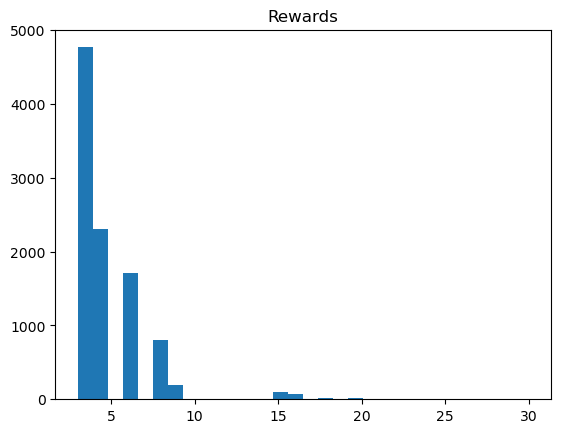

Training the model on  cpu
Epoch:  2999 Loss:  44.235816955566406 Lr:  [0.0009259991601383575]]
Time taken to train the model:  73.94965052604675
Mean reward:  7.054999828338623
Max reward:  32.0


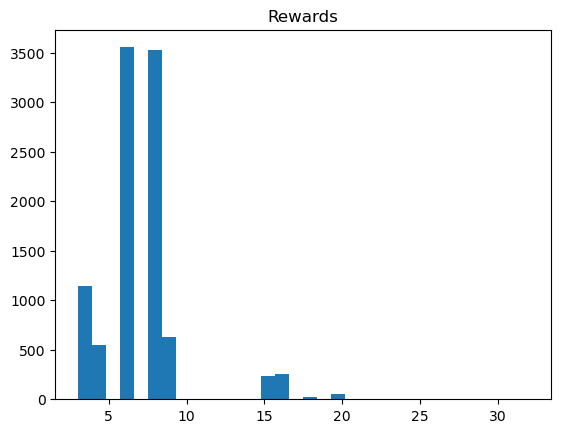

Training the model on  cpu
Epoch:  4499 Loss:  40.131439208984375 Lr:  [0.00013409075144193118]
Time taken to train the model:  92.09198594093323
Mean reward:  7.708600044250488
Max reward:  33.0


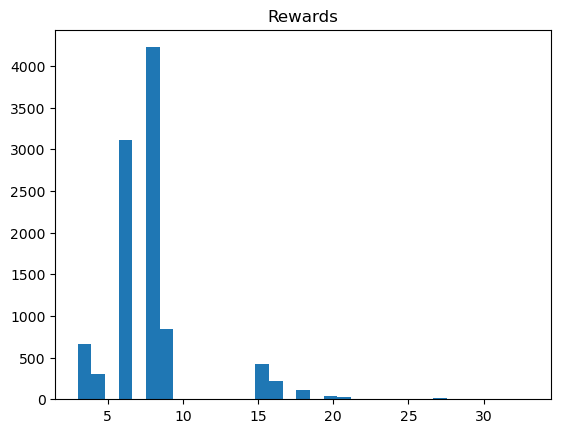

Training the model on  cpu
Epoch:  5999 Loss:  39.78009796142578 Lr:  [0.0009274382501605865]]]
Time taken to train the model:  99.34562611579895
Mean reward:  8.290399551391602
Max reward:  39.0


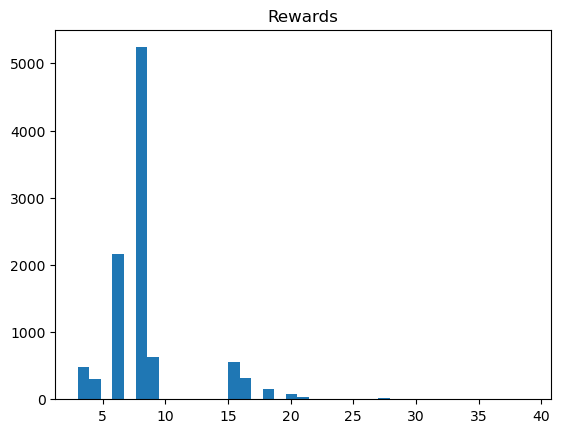

Training the model on  cpu
Epoch:  7499 Loss:  45.69785690307617 Lr:  [0.0005523659357053123]]
Time taken to train the model:  108.59429264068604
Mean reward:  9.086999893188477
Max reward:  33.0


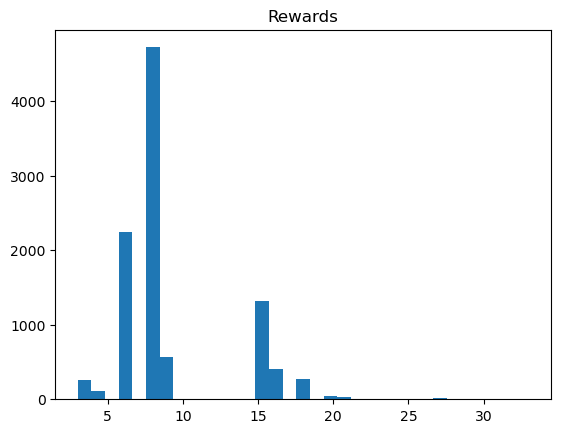

In [5]:
for i in range(5):
    model = train("cpu" if torch.cuda.is_available else "cpu", model, RMSprop, {"lr": 1e-3}, num_epochs, batch_size, i * num_epochs)

    test("cpu", model, test_size, "test.png")